In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra, Affine

┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 64. # unit: angstrom
xavg = 0.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V(x)$ and $p_{\rm eq}(x)$

In [3]:
sigma_kref = 8.
kref = get_k_by_sigma(sigma_kref)
Vref = harmonic_well_k_mean(xref, kref, xavg)
rho_eq = get_rhoeq(Vref, w0)
p_eq = rho_eq .* rho_eq;

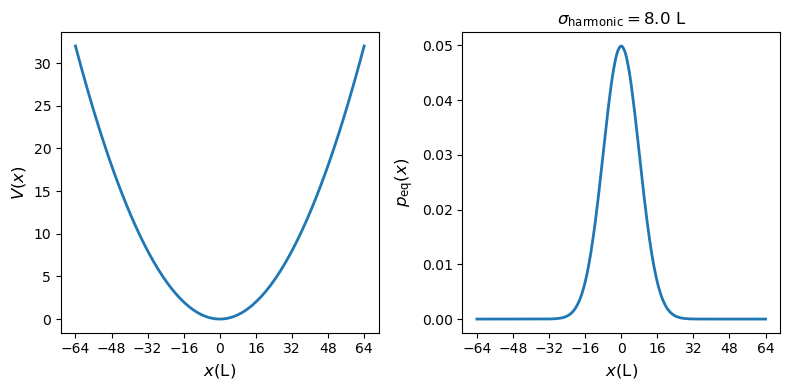

In [4]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8,4))

ax = axes[1]
ax.plot(xref, Vref, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$V(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
#ax.set_ylim(0, 10)

ax = axes[2]
ax.plot(xref, p_eq, linewidth=2)
ax.set_xlabel("\$x\$(L)", fontsize=12)
ax.set_ylabel("\$p_{\\rm eq}(x)\$", fontsize=12)
ax.set_xticks(-64:16:64)
ax.set_title(@sprintf "\$\\sigma_{\\rm harmonic} = %.1f\$ L" sigma_kref)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/harmonic_well_r.svg")
plt.show()

### Part 3: Set parameters about simulations

In [4]:
# physical parameters
save_freq = 1e-2 # unit: s, Save trajectory per 1e-2 s
total_times = 100 # unit: s, totol simulate 100 s
dt = 2e-5 # unit: s  # Integration Times 1ps
D = 500; # Diffusion coefficient, unit: s-1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 500 timesteps. There will be 10000 data points.


In [5]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_well_r_0.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

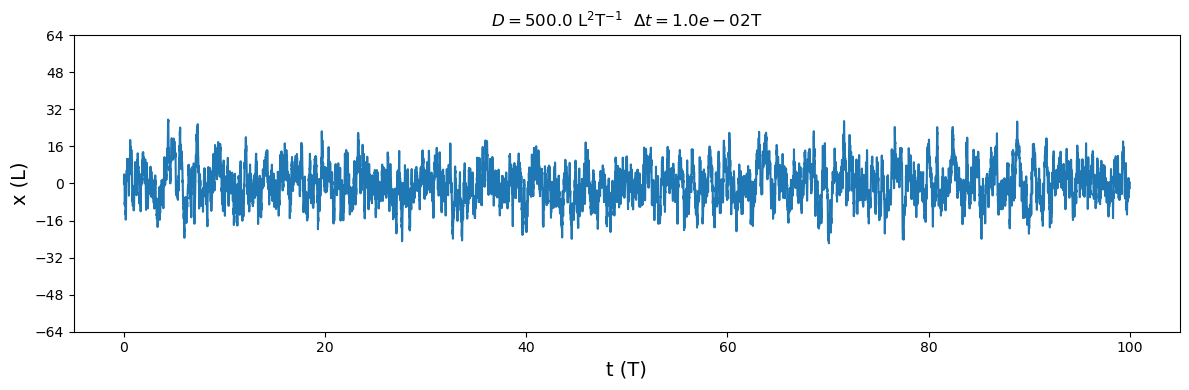

In [7]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))

ax.plot(t_record, y_record)
ax.set_ylabel("x (L)", fontsize=lbfz)
ax.set_xlabel("t (T)", fontsize=lbfz)
ax.set_title(@sprintf "\$ D=%.1f\$ L\$^{2}\$T\$^{-1}\$  \$\\Delta t=%.1e\$T " D save_freq)
ax.set_yticks(-64:16:64)

plt.tight_layout()
#plt.savefig("/home/yizaochen/Desktop/drawzone_temp/0/reduced_traj.svg")
plt.show()

### Part 4: Set the force constant($\sigma$ of Gaussian) of Photon Operator

In [29]:
## Photon Operator
sigma_photon = 0.5 # unit: L
k_photon = get_k_by_sigma(sigma_photon);

### Part 5: Get log-likelihood test

In [9]:
D_test = 100.
log_likelihood = get_loglikelihood(Nh, Np, xratio, xavg, p_eq, D_test, Nv, tau, y_record, save_freq, k_photon);

### Part 6: Scan $l$ as change D and fix $p_{\rm eq}=p_0$

In [30]:
# Set D-array and peq
D_array = 250.:10.:550.

l_array_v00 = zeros(length(D_array))
l_array_v01 = zeros(length(D_array))
l_array_v1 = zeros(length(D_array))

peq_scan_D = zeros(N, 1)
peq_scan_D[:, 1] = p_eq; # p0
# D_array = float(vcat(D_array_1, D_array_2, D_array_3))

In [31]:
d_idx = 1
for D_test in D_array
    l_array_v00[d_idx] = get_loglikelihood_v0(Nh, Np, xratio, xavg, peq_scan_D, D_test, Nv, tau, y_record, save_freq, k_photon)
    l_array_v01[d_idx] = get_loglikelihood_v01(Nh, Np, xratio, xavg, peq_scan_D, D_test, Nv, tau, y_record, save_freq, k_photon)
    l_array_v1[d_idx] = get_loglikelihood_v1(Nh, Np, xratio, xavg, peq_scan_D, D_test, Nv, tau, y_record, save_freq, k_photon)
    d_idx += 1
end

### Part 7:
#### Scheme 0.0 : $\left(\left< \hat{\alpha}_{t_{i}} | x\right>\right)^2$ as probability, without normalizing $\left< \hat{\alpha}_{t_{i}} \right| e^{-\textbf{H}\Delta t}$
#### Scheme 0.1 : $\left(\left< \hat{\alpha}_{t_{i}} | x\right>\right)^2$ as probability, with normalizing $\left< \hat{\alpha}_{t_{i}} \right| e^{-\textbf{H}\Delta t}$
#### Scheme 1.0 : $\left< \hat{\alpha}_{t_{i}} | x\right>\rho_{\rm{eq}}(x)$ as probability

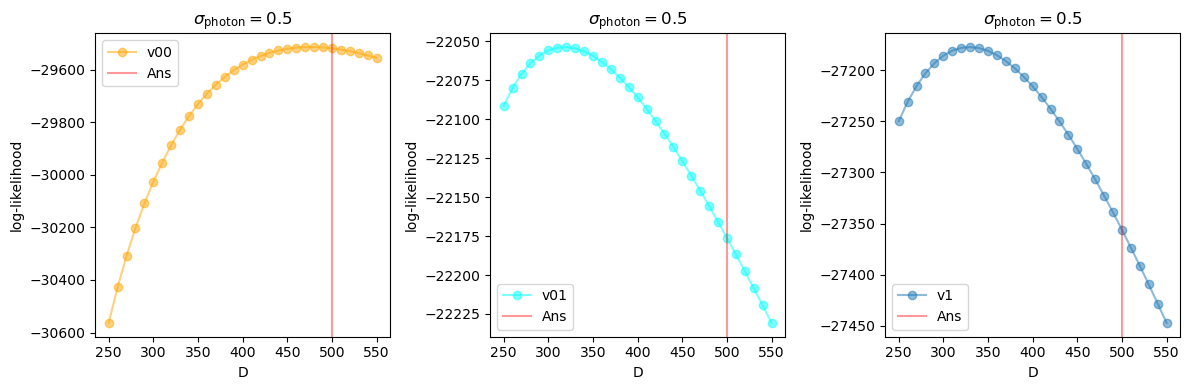

In [32]:
fig, axes_0 = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

ax = axes_0[1]
ax.plot(D_array, l_array_v00, "-o", color="orange", alpha=0.5, label="v00")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D")
ax.axvline(D, color="red", alpha=0.4, label="Ans")
ax.legend()
ax.set_title(@sprintf "\$\\sigma_{\\mathrm{photon}}=\$%.1f" sigma_photon)

ax = axes_0[2]
ax.plot(D_array, l_array_v01, "-o", color="cyan", alpha=0.5, label="v01")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D")
ax.axvline(D, color="red", alpha=0.4, label="Ans")
ax.legend()
ax.set_title(@sprintf "\$\\sigma_{\\mathrm{photon}}=\$%.1f" sigma_photon)

ax = axes_0[3]
ax.plot(D_array, l_array_v1,  "-o", alpha=0.5, label="v1")
ax.set_ylabel("log-likelihood")
ax.set_xlabel("D")
ax.axvline(D, color="red", alpha=0.4, label="Ans")
ax.legend()
ax.set_title(@sprintf "\$\\sigma_{\\mathrm{photon}}=\$%.1f" sigma_photon)

plt.tight_layout()
#plt.savefig(@sprintf "/home/yizaochen/Desktop/drawzone_temp/sigma%.1f.svg" sigma_photon)
plt.show()